In [243]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from spire.doc import *
from spire.doc.common import *
from IPython.display import Image
from PIL import Image as PILImage

In [244]:
from FuncionesMineria import(
    analizar_variables_categoricas,
    cuentaDistintos, 
    frec_variables_num, 
    atipicosAmissing, 
    patron_perdidos,
    ImputacionCuant,
    ImputacionCuali,
    Vcramer,
    hist_targetbinaria,
    lm_stepwise,
    lm_backward,
    lm_forward,
    Rsq,
    crear_data_modelo
)

<h2> 2 - Preparacion de Datos </h2>

<h3>Extraccion de datos</h3>

In [245]:
datos = pd.read_excel("../Statement/DatosEleccionesEspaña.xlsx")

<h3>Asignar tipo de datos correctos</h3>

In [246]:
# Asignar tipo de datos correctos

colsFromFloatToInt = ["totalEmpresas", "Industria", "Construccion", "ComercTTEHosteleria", "Servicios", "inmuebles", "Pob2010", "PersonasInmueble"]
colsFromIntToBool = ["Izquierda", "Derecha", "AbstencionAlta"]

for c in colsFromFloatToInt:
    datos[c] = datos[c].fillna(-1)
    datos[c] = datos[c].astype(int)

for c in colsFromFloatToInt:
    datos[c] = datos[c].replace(-1, np.nan)

for c in colsFromIntToBool:
    datos[c] = datos[c].astype(bool)

<h3>3 - Analisis Descriptivo </h3>

In [247]:
print(analizar_variables_categoricas(datos))
print(cuentaDistintos(datos))
print(datos.describe().T)

{'Name':                    n         %
Mieres             2  0.000246
Cieza              2  0.000246
Moya               2  0.000246
Rebollar           2  0.000246
Villaescusa        2  0.000246
...               ..       ...
Muras              1  0.000123
Monterroso         1  0.000123
Monforte de Lemos  1  0.000123
Mondoñedo          1  0.000123
Zuñeda             1  0.000123

[8100 rows x 2 columns], 'CCAA':                    n         %
CastillaLeón    2248  0.276950
Cataluña         947  0.116669
CastillaMancha   919  0.113219
Andalucía        773  0.095232
Aragón           731  0.090058
ComValenciana    542  0.066773
Extremadura      387  0.047678
Galicia          314  0.038684
Navarra          272  0.033510
PaísVasco        251  0.030923
Madrid           179  0.022052
Rioja            174  0.021436
Cantabria        102  0.012566
Canarias          88  0.010841
Asturias          78  0.009609
Baleares          67  0.008254
Murcia            45  0.005544, 'AbstencionAlta':         

In [248]:
datos[datos.columns].isna().sum()

Name                              0
CodigoProvincia                   0
CCAA                              0
Population                        0
TotalCensus                       0
AbstentionPtge                    0
AbstencionAlta                    0
Izda_Pct                          0
Dcha_Pct                          0
Otros_Pct                         0
Izquierda                         0
Derecha                           0
Age_0-4_Ptge                      0
Age_under19_Ptge                  0
Age_19_65_pct                     0
Age_over65_pct                    0
WomanPopulationPtge               0
ForeignersPtge                    0
SameComAutonPtge                  0
SameComAutonDiffProvPtge          0
DifComAutonPtge                   0
UnemployLess25_Ptge               0
Unemploy25_40_Ptge                0
UnemployMore40_Ptge               0
AgricultureUnemploymentPtge       0
IndustryUnemploymentPtge          0
ConstructionUnemploymentPtge      0
ServicesUnemploymentPtge    

<h2>4 - Corrección de los errores detectados. </h2>
<h3>Tratamiento de datos incorrectos </h3>

In [249]:
categoricas = ["Densidad", "Population", "Name", "CCAA"]

for c in categoricas:
    datos[c] = datos[c].replace('nan',np.nan)

datos["Densidad"] = datos["Densidad"].replace('?', np.nan)

Vamos a tratar a las variables que representan porcentajes para poner como valor perdido cualquier observacion por fuera del rango de un porcentaje (0-100) la unica excepcion es la variable "PobChange_pct" ya que explicitamente esta explicado que los valores negativos aportan informacion

In [250]:
porcentajes = [
    "WomanPopulationPtge", "ForeignersPtge", "SameComAutonPtge", "SameComAutonDiffProvPtge", "DifComAutonPtge",
    "UnemployLess25_Ptge", "Unemploy25_40_Ptge", "UnemployMore40_Ptge", "AgricultureUnemploymentPtge", "IndustryUnemploymentPtge",
    "ConstructionUnemploymentPtge", "ServicesUnemploymentPtge", "AbstentionPtge", "Izda_Pct", "Dcha_Pct", "Otros_Pct", "Age_0-4_Ptge",
    "Age_under19_Ptge", "Age_19_65_pct", "Age_over65_pct"]

for c in porcentajes:
    datos[c] = [x if 0 <= x <= 100 else np.nan for x in datos[c]]

In [251]:

datos["ActividadPpal"] = datos["ActividadPpal"].replace(["Otro"], "Otros")


<h3>Eliminar variables objetivo y codificadora</h3>

<ul>
    <li>Izda Pct: Porcentaje de votos a partidos de izquierda (PSOE y Podemos) </li>
    <li>Izquierda: Variable dicotómica que toma el valor 1 si la suma de los votos de izquierdas es superior a la de derechas y otros y, 0, en otro caso. </li>
</ul>

In [252]:
varObjIzdaPct = datos["Izda_Pct"]
varObjIzquierda = datos["Izquierda"]

datos_input = datos.drop(["Izda_Pct", "Izquierda", "Name", "CodigoProvincia", "Dcha_Pct", "Otros_Pct", "AbstencionAlta", "Derecha"], axis=1)

<h3>5 - Analisis de valores atipicos y perdidos</h3>

In [253]:
numericas_input = datos_input.select_dtypes(include=['int', 'int32', 'int64', 'float', 'float32', 'float64']).columns
categoricas_input = [variable for variable in list(datos_input.columns) if variable not in numericas_input]

calculamos porcentaje de atipicos de cada una de las variables continuas en el conjunto de datos.

In [254]:
pctAtipicosContinuas = {x: atipicosAmissing(datos_input[x])[1]/len(datos_input) for x in numericas_input}

<p>analizando el resultado observamos que las unicas que presentan valores atipicoss algo significativos es son la variable "Otros_Pct"(10.3%), la variable "Population"(9.9%) y "TotalCensus" (9.6%)</p>

<p>Vamos a proceder a pasar los valores atipicos a valores perdidos</p>

In [255]:
for x in numericas_input:
    datos_input[x] = atipicosAmissing(datos_input[x])[0]

Vamos a analizar la proporocion de datos perdidos en cada una de las variables de nuestro conjunto de datos

In [256]:
propMissingPorVariable = datos_input.isna().sum()/len(datos_input)


en este punto podemos observar gran parte de las que presentan un cierto porcentaje significativo de valores perdidos son las tres que ya habiamos observados que tenian valores atipicos y los habiamos transformado a valores perdidos.

Tambien podemos observar que se han sumado una mas "ForeignersPtge" con el 8%

vamos a analizar ahora la cantidad de valores perdidos para cada observacion, para hacer eso extraemos los estadisticos de la proporcion de datos perdidos para las obsevaciones 

In [257]:
datos_input['props_missings'] = datos_input.isna().mean(axis=1)

de esta informacion concluimos que la media de datos perdidos por observacion es del 3% la observacion que mas variable perdidas tiene presenta el 28% de variables perdidas por lo que concluimos que no hace falta eliminar ninguna observacion ya que todas aportan una cantidad significativa de informacion

<h2>6 - Tratamiento de valores atipicos o perdidos </h2>

Las variables categoricas casi no presentan valores perdidos pero para evitar que los pocos que hayan provoquen distorision en la estimacion de la variable objetivo vamos a asignarle valores aleatorios.

En el caso de las variables numericas existen varias con algun porcentaje significativo de valores perdidos, para no perder la distribucion que originalmente presentan tambien vamos a otrgarle valores aleatorios. 

In [258]:
for x in numericas_input:
    datos_input[x] = ImputacionCuant(datos_input[x], 'aleatorio')

for x in categoricas_input:
    datos_input[x] = ImputacionCuali(datos_input[x], 'aleatorio')

datos_input.isna().sum()

CCAA                            0
Population                      0
TotalCensus                     0
AbstentionPtge                  0
Age_0-4_Ptge                    0
Age_under19_Ptge                0
Age_19_65_pct                   0
Age_over65_pct                  0
WomanPopulationPtge             0
ForeignersPtge                  0
SameComAutonPtge                0
SameComAutonDiffProvPtge        0
DifComAutonPtge                 0
UnemployLess25_Ptge             0
Unemploy25_40_Ptge              0
UnemployMore40_Ptge             0
AgricultureUnemploymentPtge     0
IndustryUnemploymentPtge        0
ConstructionUnemploymentPtge    0
ServicesUnemploymentPtge        0
totalEmpresas                   0
Industria                       0
Construccion                    0
ComercTTEHosteleria             0
Servicios                       0
ActividadPpal                   0
inmuebles                       0
Pob2010                         0
SUPERFICIE                      0
Densidad      

Al finalizar la depuracion guardamos los datos en nuevo fichero para tenerlo listo para trabajar sobre el conservando las fuentes de datos originales por si queremos volver para atras en alguna de las tareas que hicimos para depurar por algun error que hayamos cometido en el proceso

In [259]:
datosEleccionesEspañaDep = pd.concat([varObjIzquierda, varObjIzdaPct, datos_input], axis=1)
with open('datosEleccionesEspañaDep.pickle', 'wb') as archivo:
    pickle.dump(datosEleccionesEspañaDep, archivo)


<h2>7 - Analisis de relaciones entre variables<h2>

In [260]:
with open('datosEleccionesEspañaDep.pickle', 'rb') as f:
    datos_dep=pickle.load(f)

<h3>Variables objetivo con variables predictoras</h3>

Separamos las variables explicativas de las variables objetivo, excluimos las codificadoras

In [261]:
varObjIzdaPct = datos_dep['Izda_Pct']
varObjIzquierda = datos_dep['Izquierda']

datos_input = datos_dep.drop(['Izda_Pct', 'Izquierda', 'CCAA'], axis=1)

nombres_variables = list(datos_input.columns)

<h4>Izquierda</h4>

In [262]:

resultados_izquierda = []
for v in nombres_variables:
    coeficiente_cramer = Vcramer(datos_input[v], varObjIzquierda)
    resultados_izquierda.append((v,coeficiente_cramer))

resultados_izquierda.sort(key=lambda x: x[1], reverse=True)

# Imprimir las variables ordenadas por valor p
print("Izquierda")
print("\nVariables predictoras significativas (ordenadas de mayor a menor asociacion ):\n")
for variable, coeficiente in resultados_izquierda:
    print(f"{variable}: Coeficiente V de Cramer = {coeficiente}")


Izquierda

Variables predictoras significativas (ordenadas de mayor a menor asociacion ):

UnemployLess25_Ptge: Coeficiente V de Cramer = 0.270169783684299
AgricultureUnemploymentPtge: Coeficiente V de Cramer = 0.20071185526123572
UnemployMore40_Ptge: Coeficiente V de Cramer = 0.18549349056399067
ActividadPpal: Coeficiente V de Cramer = 0.1758742150757248
Explotaciones: Coeficiente V de Cramer = 0.16787517447885358
SUPERFICIE: Coeficiente V de Cramer = 0.16007999364071013
inmuebles: Coeficiente V de Cramer = 0.14503169244793862
Age_over65_pct: Coeficiente V de Cramer = 0.1442486167893124
Age_under19_Ptge: Coeficiente V de Cramer = 0.1400798472767252
Population: Coeficiente V de Cramer = 0.1385196608567537
TotalCensus: Coeficiente V de Cramer = 0.13641946337831026
Pob2010: Coeficiente V de Cramer = 0.13431248096081688
Age_0-4_Ptge: Coeficiente V de Cramer = 0.13082036640640715
Unemploy25_40_Ptge: Coeficiente V de Cramer = 0.128175026286538
WomanPopulationPtge: Coeficiente V de Cramer = 

El coefieciente V de Cramer va de 0 a 1 siendo 0 el valor que representa una relacion cercana a nula y 1 una relacion perfecta. Si bien tenemos gran cantidad de variables que aportan informacion explicativa ninguna parece esta fuertemente relacionada con la variable objetivo

<h5>Grafico de similitud de las distribuciones</h5>

<p>A continuacion graficamos una comparativa de las distribuciones de las variables mas y menos significativas (de menos a mas) para Izquierda</p>


<ul>
    <li>Menos significativas: Industria  y Servicios</li>
    <li>Variable mas significativas: UnemployLess25_Ptge y AgricultureUnemploymentPtge</li>
</ul>

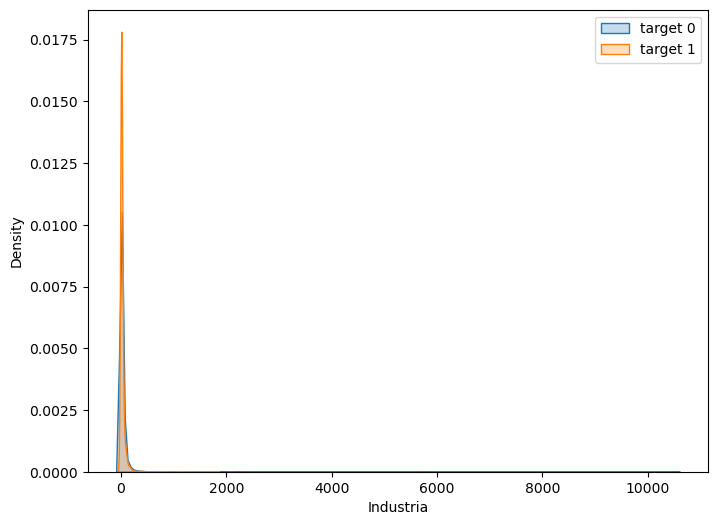

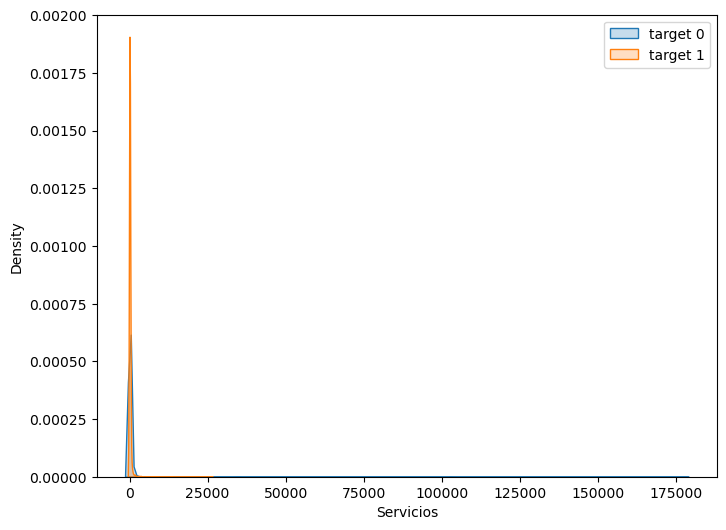

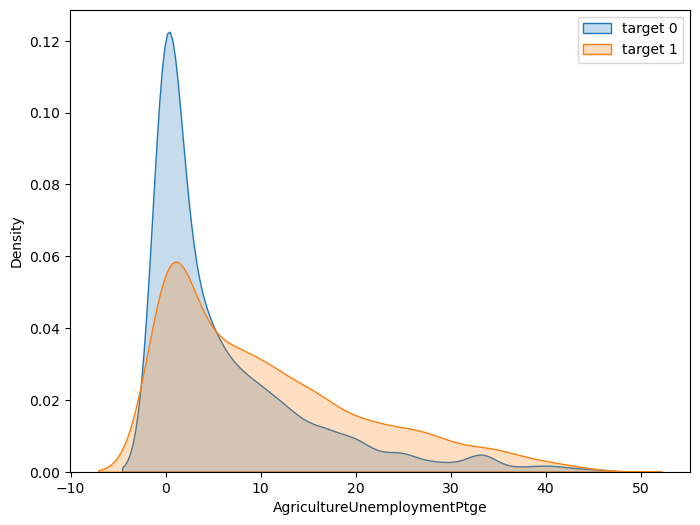

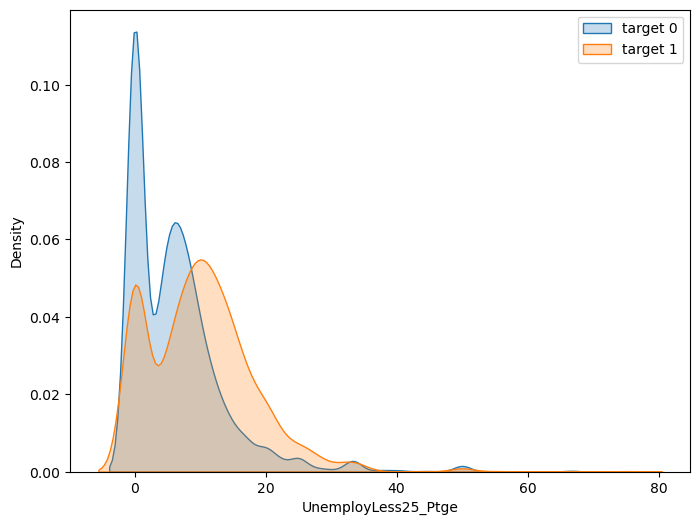

In [263]:
hist_targetbinaria(datos_input['Industria'],varObjIzquierda,'Industria')
hist_targetbinaria(datos_input['Servicios'],varObjIzquierda, 'Servicios')
hist_targetbinaria(datos_input['AgricultureUnemploymentPtge'],varObjIzquierda, 'AgricultureUnemploymentPtge')
hist_targetbinaria(datos_input['UnemployLess25_Ptge'],varObjIzquierda, 'UnemployLess25_Ptge')

<h4>Izda_Pct</h4>

In [264]:
resultados_Izda_Pct = []
for v in nombres_variables:
    coeficiente_cramer = Vcramer(datos_input[v], varObjIzdaPct)
    resultados_Izda_Pct.append((v,coeficiente_cramer))

resultados_Izda_Pct.sort(key=lambda x: x[1], reverse=True)

# Imprimir las variables ordenadas por valor p
print("Izquierda_Pct")
print("\nVariables predictoras significativas (ordenadas de mayor a menor asociacion ):\n")
for variable, coeficiente in resultados_Izda_Pct:
    print(f"{variable}: Coeficiente V de Cramer = {coeficiente}")

Izquierda_Pct

Variables predictoras significativas (ordenadas de mayor a menor asociacion ):

UnemployLess25_Ptge: Coeficiente V de Cramer = 0.20411240959368843
AgricultureUnemploymentPtge: Coeficiente V de Cramer = 0.1455296520903892
AbstentionPtge: Coeficiente V de Cramer = 0.14078541697030386
SameComAutonDiffProvPtge: Coeficiente V de Cramer = 0.12808225109675114
UnemployMore40_Ptge: Coeficiente V de Cramer = 0.12380657156559965
ActividadPpal: Coeficiente V de Cramer = 0.12001904706334858
SUPERFICIE: Coeficiente V de Cramer = 0.11774747690685447
IndustryUnemploymentPtge: Coeficiente V de Cramer = 0.11387964243882621
Age_0-4_Ptge: Coeficiente V de Cramer = 0.11072998895892325
Age_under19_Ptge: Coeficiente V de Cramer = 0.1100519036220996
Age_over65_pct: Coeficiente V de Cramer = 0.10887446731861938
Explotaciones: Coeficiente V de Cramer = 0.10799457124061025
inmuebles: Coeficiente V de Cramer = 0.1045072084898914
PersonasInmueble: Coeficiente V de Cramer = 0.10133128210208847
Pob201

<ul>
    <li>Menos significativas: Age_0-4_Ptge  y PersonasInmueble</li>
    <li>Variable mas significativas: UnemployLess25_Ptge y SUPERFICIE</li>
</ul>

<h3>Relaciones entre variables predictoras continuas </h3>

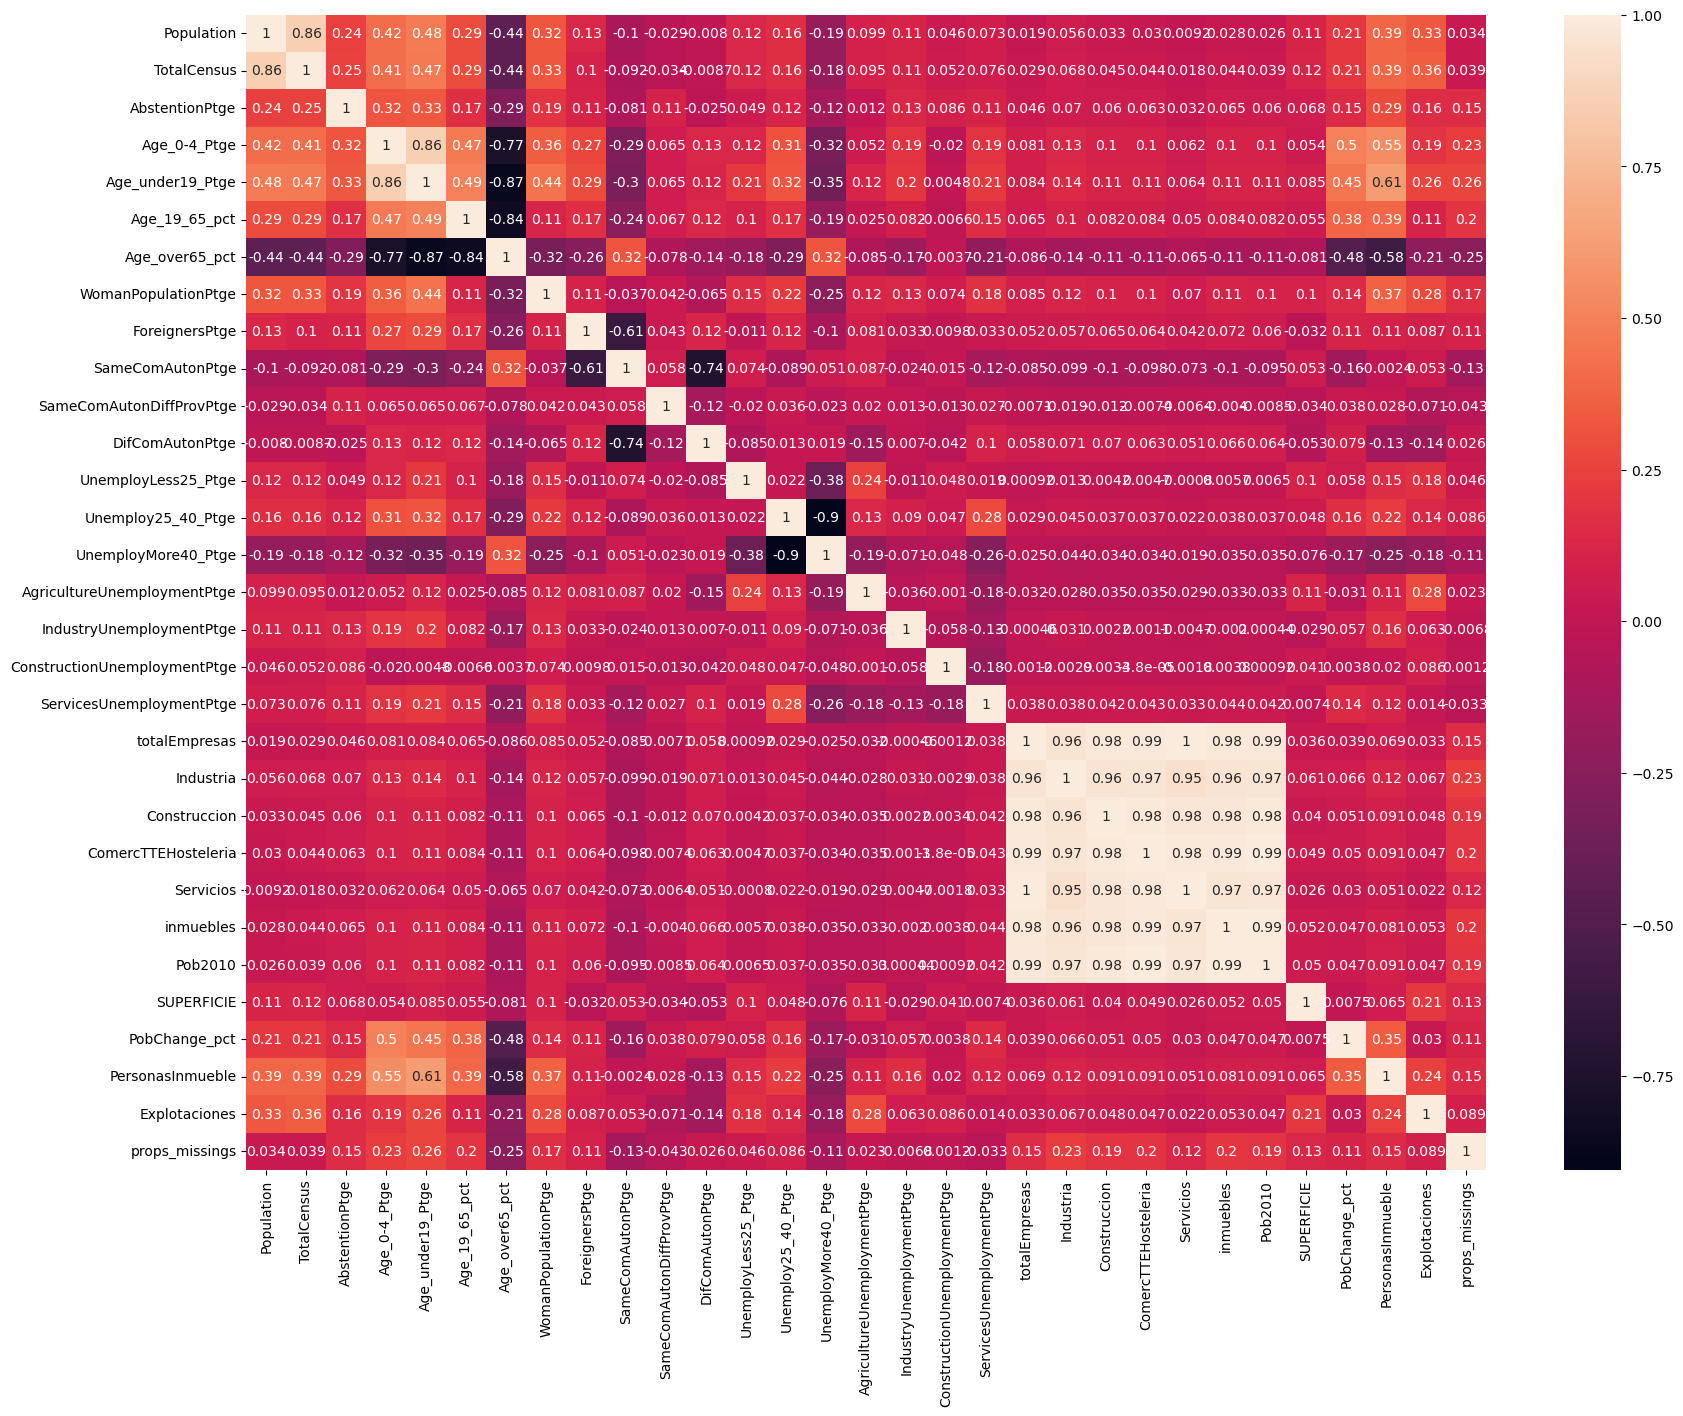

In [265]:
datos_input_continuas = datos_input.drop(['Densidad', 'ActividadPpal'], axis=1)

correlation_matrix = datos_input_continuas.corr()

# Visualizar la matriz de correlación con un mapa de calor
plt.figure(figsize=(20, 15)) 
sns.heatmap(correlation_matrix, annot=True)
plt.show()

Como se puede observar existe una fuertisima correlacion en el siguiente grupo de variables: totalEmpresas, Industria, Construccion, ComercTTEHoteleria, Servicios, inmuebles y pob2010. Al estar tan correladas la informacion que aporten para explicar la variable objetivo probablemente sea redundante entre ellas.

Analizando un poco la relacion que existe entre estas variables y las dos variables objetivos nos damos cuenta que no tienen especial relacion, de hecho (en su mayoria) estan entre las que menos relacion tienen. Debido a esto decidi que voy a remover del conjunto de datos todas menos una de las variables, dejando solo la que mejor desempeño tiene en cuanto a la relacion que presenta con las variables objetivo: "inmuebles"

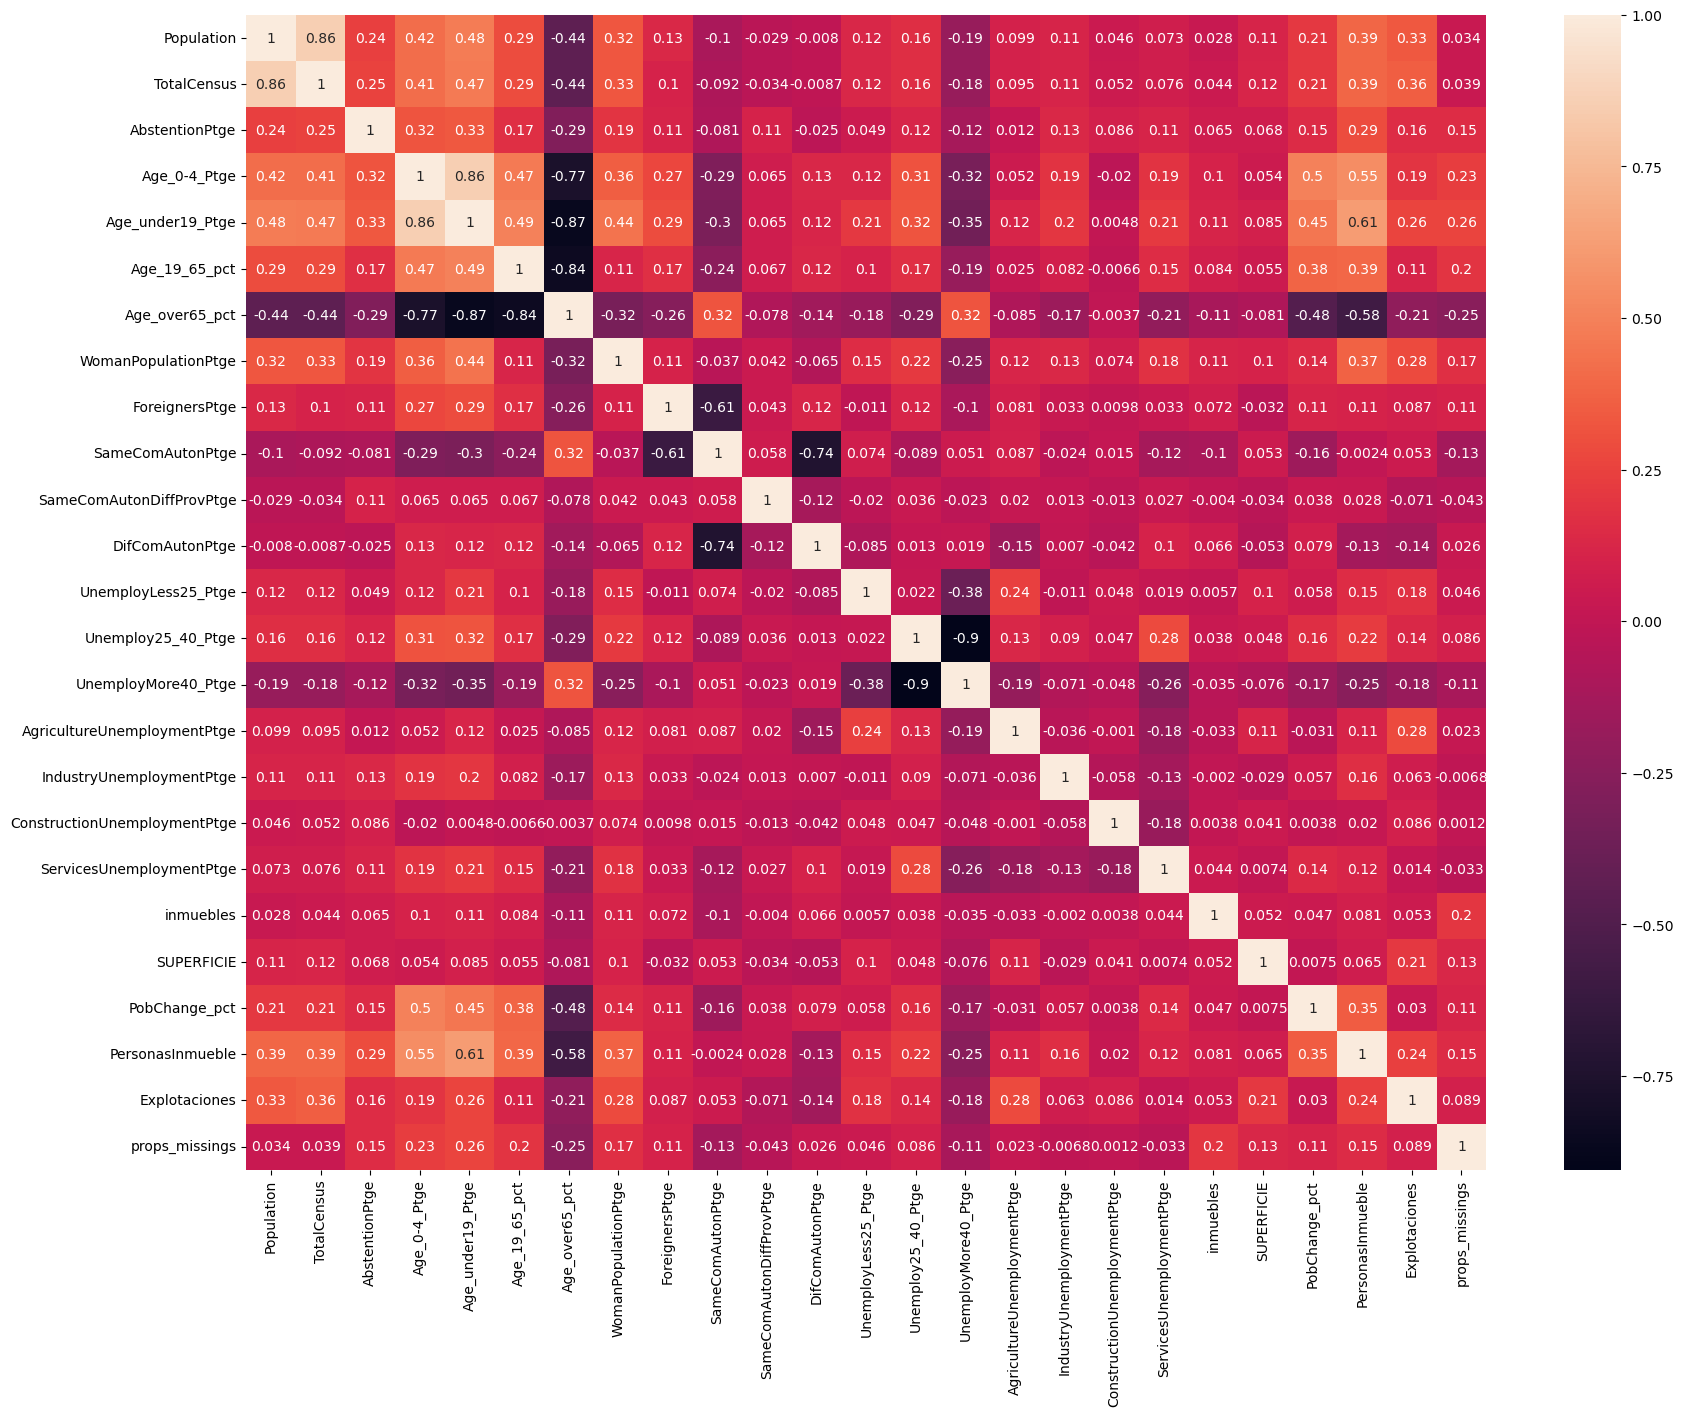

In [266]:
datos_input = datos_input.drop(['ComercTTEHosteleria', 'Industria', 'Servicios', 'Construccion', 'totalEmpresas', 'Pob2010'], axis=1)

datos_input_continuas = datos_input.drop(['Densidad', 'ActividadPpal'], axis=1)

correlation_matrix = datos_input_continuas.corr()

# Visualizar la matriz de correlación con un mapa de calor
plt.figure(figsize=(20, 15)) 
sns.heatmap(correlation_matrix, annot=True)
plt.show()

<h2> 8 - Elaboracion del modelo de Regresion Lineal</h2>

<h3>Muestras de entrenamiento y Test<h3>

Realizamos las particiones del conjunto de datos para entrenamiento del modelo y test, vamos a tener en cuenta todas las variables que han pasado por nuestra depuracion. Las particiones de datos para entrenamiento y prueba se hacen de manera independiente para cada variable objetivo.

In [267]:
izquierda_predictoras_train, izquierda_predictoras_test,izquierda_objetivo_train, izquierda_objetivo_test=train_test_split(
    datos_input, varObjIzquierda, test_size=0.2, random_state=123456)

izq_pct_predictoras_train, izq_pct_predictoras_test, izq_pct_objetivo_train, izq_pct_objetivo_test=train_test_split(
    datos_input, varObjIzdaPct, test_size=0.2, random_state=123456)


variables_predictoras_continuas = ['Population', 'TotalCensus', 'AbstentionPtge', 'Age_0-4_Ptge',
       'Age_under19_Ptge', 'Age_19_65_pct', 'Age_over65_pct',
       'WomanPopulationPtge', 'ForeignersPtge', 'SameComAutonPtge',
       'SameComAutonDiffProvPtge', 'DifComAutonPtge', 'UnemployLess25_Ptge',
       'Unemploy25_40_Ptge', 'UnemployMore40_Ptge',
       'AgricultureUnemploymentPtge', 'IndustryUnemploymentPtge',
       'ConstructionUnemploymentPtge', 'ServicesUnemploymentPtge',
       'inmuebles', 'SUPERFICIE', 'PobChange_pct',
       'PersonasInmueble', 'Explotaciones']

variables_predictoras_categoricas = ['Densidad', 'ActividadPpal']


<h3>Modelos a partir de metodos clasicos de seleccion de variables</h3>

<h4>Variable Objetivo Izquierda</h4>

<h5>Método Backward</h5>

In [268]:
rl_izquierda_backward_aic = lm_stepwise(izquierda_objetivo_train, izquierda_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas, metodo="AIC")

data_rl_izquierda_backward_aic = crear_data_modelo(izquierda_predictoras_test, rl_izquierda_backward_aic['Variables']['cont'], 
                                                rl_izquierda_backward_aic['Variables']['categ'], 
                                                rl_izquierda_backward_aic['Variables']['inter'])

Start: AIC = 7081.927499268448

y ~ 1

                       Variable         AIC
          + UnemployLess25_Ptge 6828.647711
  + AgricultureUnemploymentPtge 6863.455605
                + ActividadPpal 6892.504112
                + Explotaciones 6931.805570
                   + SUPERFICIE 6951.645771
          + UnemployMore40_Ptge 6995.367639
               + Age_over65_pct 7014.158396
     + SameComAutonDiffProvPtge 7020.886311
                + Age_19_65_pct 7021.320247
                  + TotalCensus 7027.429311
                   + Population 7029.185233
             + Age_under19_Ptge 7036.210563
               + ForeignersPtge 7042.980058
          + WomanPopulationPtge 7044.916211
             + PersonasInmueble 7049.937876
     + IndustryUnemploymentPtge 7053.453865
 + ConstructionUnemploymentPtge 7065.007019
           + Unemploy25_40_Ptge 7065.712415
             + SameComAutonPtge 7076.029952
               + AbstentionPtge 7077.107001
                     + Densidad 7077.

In [269]:
rl_izquierda_backward_bic = lm_stepwise(izquierda_objetivo_train, izquierda_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas, metodo="BIC")

data_rl_izquierda_backward_bic = crear_data_modelo(izquierda_predictoras_test, rl_izquierda_backward_bic['Variables']['cont'], 
                                                rl_izquierda_backward_bic['Variables']['categ'], 
                                                rl_izquierda_backward_bic['Variables']['inter'])

Start: BIC = 7088.705979220957

y ~ 1

                       Variable         BIC
          + UnemployLess25_Ptge 6842.204671
  + AgricultureUnemploymentPtge 6877.012565
                + ActividadPpal 6926.396512
                + Explotaciones 6945.362530
                   + SUPERFICIE 6965.202731
          + UnemployMore40_Ptge 7008.924599
               + Age_over65_pct 7027.715356
     + SameComAutonDiffProvPtge 7034.443271
                + Age_19_65_pct 7034.877207
                  + TotalCensus 7040.986271
                   + Population 7042.742193
             + Age_under19_Ptge 7049.767523
               + ForeignersPtge 7056.537018
          + WomanPopulationPtge 7058.473171
             + PersonasInmueble 7063.494835
     + IndustryUnemploymentPtge 7067.010825
 + ConstructionUnemploymentPtge 7078.563979
           + Unemploy25_40_Ptge 7079.269375
             + SameComAutonPtge 7089.586912
               + AbstentionPtge 7090.663961
                 + Age_0-4_Ptge 7091.

<h5>Metodo Forward</h5>

In [270]:
rl_izquierda_forward_aic =  lm_forward(izquierda_objetivo_train, izquierda_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas, metodo="AIC")

data_rl_izquierda_forward_aic = crear_data_modelo(izquierda_predictoras_test, rl_izquierda_forward_aic['Variables']['cont'], 
                                                rl_izquierda_forward_aic['Variables']['categ'], 
                                                rl_izquierda_forward_aic['Variables']['inter'])

Start: AIC = 7081.927499268448

y ~ 1

                       Variable         AIC
          + UnemployLess25_Ptge 6828.647711
  + AgricultureUnemploymentPtge 6863.455605
                + ActividadPpal 6892.504112
                + Explotaciones 6931.805570
                   + SUPERFICIE 6951.645771
          + UnemployMore40_Ptge 6995.367639
               + Age_over65_pct 7014.158396
     + SameComAutonDiffProvPtge 7020.886311
                + Age_19_65_pct 7021.320247
                  + TotalCensus 7027.429311
                   + Population 7029.185233
             + Age_under19_Ptge 7036.210563
               + ForeignersPtge 7042.980058
          + WomanPopulationPtge 7044.916211
             + PersonasInmueble 7049.937876
     + IndustryUnemploymentPtge 7053.453865
 + ConstructionUnemploymentPtge 7065.007019
           + Unemploy25_40_Ptge 7065.712415
             + SameComAutonPtge 7076.029952
               + AbstentionPtge 7077.107001
                     + Densidad 7077.

In [271]:
rl_izquierda_forward_bic =  lm_forward(izquierda_objetivo_train, izquierda_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas, metodo="BIC")

data_rl_izquierda_forward_bic = crear_data_modelo(izquierda_predictoras_test, rl_izquierda_forward_bic['Variables']['cont'], 
                                                rl_izquierda_forward_bic['Variables']['categ'], 
                                                rl_izquierda_forward_bic['Variables']['inter'])

Start: BIC = 7088.705979220957

y ~ 1

                       Variable         BIC
          + UnemployLess25_Ptge 6842.204671
  + AgricultureUnemploymentPtge 6877.012565
                + ActividadPpal 6926.396512
                + Explotaciones 6945.362530
                   + SUPERFICIE 6965.202731
          + UnemployMore40_Ptge 7008.924599
               + Age_over65_pct 7027.715356
     + SameComAutonDiffProvPtge 7034.443271
                + Age_19_65_pct 7034.877207
                  + TotalCensus 7040.986271
                   + Population 7042.742193
             + Age_under19_Ptge 7049.767523
               + ForeignersPtge 7056.537018
          + WomanPopulationPtge 7058.473171
             + PersonasInmueble 7063.494835
     + IndustryUnemploymentPtge 7067.010825
 + ConstructionUnemploymentPtge 7078.563979
           + Unemploy25_40_Ptge 7079.269375
             + SameComAutonPtge 7089.586912
               + AbstentionPtge 7090.663961
                 + Age_0-4_Ptge 7091.

<h5>Metodo Stepwise</h5>

In [272]:
rl_izquierda_stepwise_aic =  lm_stepwise(izquierda_objetivo_train, izquierda_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas, metodo="AIC")

data_rl_izquierda_stepwise_aic = crear_data_modelo(izquierda_predictoras_test, rl_izquierda_stepwise_aic['Variables']['cont'], 
                                                rl_izquierda_stepwise_aic['Variables']['categ'], 
                                                rl_izquierda_stepwise_aic['Variables']['inter'])

Start: AIC = 7081.927499268448

y ~ 1

                       Variable         AIC
          + UnemployLess25_Ptge 6828.647711
  + AgricultureUnemploymentPtge 6863.455605
                + ActividadPpal 6892.504112
                + Explotaciones 6931.805570
                   + SUPERFICIE 6951.645771
          + UnemployMore40_Ptge 6995.367639
               + Age_over65_pct 7014.158396
     + SameComAutonDiffProvPtge 7020.886311
                + Age_19_65_pct 7021.320247
                  + TotalCensus 7027.429311
                   + Population 7029.185233
             + Age_under19_Ptge 7036.210563
               + ForeignersPtge 7042.980058
          + WomanPopulationPtge 7044.916211
             + PersonasInmueble 7049.937876
     + IndustryUnemploymentPtge 7053.453865
 + ConstructionUnemploymentPtge 7065.007019
           + Unemploy25_40_Ptge 7065.712415
             + SameComAutonPtge 7076.029952
               + AbstentionPtge 7077.107001
                     + Densidad 7077.

In [273]:
rl_izquierda_stepwise_bic =  lm_stepwise(izquierda_objetivo_train, izquierda_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas, metodo="BIC")

data_rl_izquierda_stepwise_bic = crear_data_modelo(izquierda_predictoras_test, rl_izquierda_stepwise_bic['Variables']['cont'], 
                                                rl_izquierda_stepwise_bic['Variables']['categ'], 
                                                rl_izquierda_stepwise_bic['Variables']['inter'])

Start: BIC = 7088.705979220957

y ~ 1

                       Variable         BIC
          + UnemployLess25_Ptge 6842.204671
  + AgricultureUnemploymentPtge 6877.012565
                + ActividadPpal 6926.396512
                + Explotaciones 6945.362530
                   + SUPERFICIE 6965.202731
          + UnemployMore40_Ptge 7008.924599
               + Age_over65_pct 7027.715356
     + SameComAutonDiffProvPtge 7034.443271
                + Age_19_65_pct 7034.877207
                  + TotalCensus 7040.986271
                   + Population 7042.742193
             + Age_under19_Ptge 7049.767523
               + ForeignersPtge 7056.537018
          + WomanPopulationPtge 7058.473171
             + PersonasInmueble 7063.494835
     + IndustryUnemploymentPtge 7067.010825
 + ConstructionUnemploymentPtge 7078.563979
           + Unemploy25_40_Ptge 7079.269375
             + SameComAutonPtge 7089.586912
               + AbstentionPtge 7090.663961
                 + Age_0-4_Ptge 7091.

<h4>Variable Objetivo Izq_Pct</h4>

<h5>Metodo Backward</h5>

In [274]:
rl_izq_pct_backward_aic =  lm_backward(izq_pct_objetivo_train, izq_pct_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas, metodo="AIC")

data_rl_izq_pct_backward_aic = crear_data_modelo(izq_pct_predictoras_test, rl_izq_pct_backward_aic['Variables']['cont'], 
                                                rl_izq_pct_backward_aic['Variables']['categ'], 
                                                rl_izq_pct_backward_aic['Variables']['inter'])

Start: AIC = 52988.09698741319

y ~ Population + TotalCensus + AbstentionPtge + Age_0-4_Ptge + Age_under19_Ptge + Age_19_65_pct + Age_over65_pct + WomanPopulationPtge + ForeignersPtge + SameComAutonPtge + SameComAutonDiffProvPtge + DifComAutonPtge + UnemployLess25_Ptge + Unemploy25_40_Ptge + UnemployMore40_Ptge + AgricultureUnemploymentPtge + IndustryUnemploymentPtge + ConstructionUnemploymentPtge + ServicesUnemploymentPtge + inmuebles + SUPERFICIE + PobChange_pct + PersonasInmueble + Explotaciones + Densidad + ActividadPpal

                       Variable          AIC
     - SameComAutonDiffProvPtge 53234.445746
  - AgricultureUnemploymentPtge 53113.000669
                - ActividadPpal 53088.377007
                   - SUPERFICIE 53076.908272
     - IndustryUnemploymentPtge 53073.555566
          - UnemployLess25_Ptge 53066.414720
               - AbstentionPtge 53065.847464
              - DifComAutonPtge 53050.437864
 - ConstructionUnemploymentPtge 53018.860232
                 -

In [275]:
rl_izq_pct_backward_bic =  lm_backward(izq_pct_objetivo_train, izq_pct_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas, metodo="BIC")

data_rl_izq_pct_backward_bic = crear_data_modelo(izq_pct_predictoras_test, rl_izq_pct_backward_bic['Variables']['cont'], 
                                                rl_izq_pct_backward_bic['Variables']['categ'], 
                                                rl_izq_pct_backward_bic['Variables']['inter'])

Start: BIC = 53198.22986594096

y ~ Population + TotalCensus + AbstentionPtge + Age_0-4_Ptge + Age_under19_Ptge + Age_19_65_pct + Age_over65_pct + WomanPopulationPtge + ForeignersPtge + SameComAutonPtge + SameComAutonDiffProvPtge + DifComAutonPtge + UnemployLess25_Ptge + Unemploy25_40_Ptge + UnemployMore40_Ptge + AgricultureUnemploymentPtge + IndustryUnemploymentPtge + ConstructionUnemploymentPtge + ServicesUnemploymentPtge + inmuebles + SUPERFICIE + PobChange_pct + PersonasInmueble + Explotaciones + Densidad + ActividadPpal

                       Variable          BIC
     - SameComAutonDiffProvPtge 53437.800144
  - AgricultureUnemploymentPtge 53316.355068
                   - SUPERFICIE 53280.262670
     - IndustryUnemploymentPtge 53276.909964
                - ActividadPpal 53271.395965
          - UnemployLess25_Ptge 53269.769119
               - AbstentionPtge 53269.201862
              - DifComAutonPtge 53253.792262
 - ConstructionUnemploymentPtge 53222.214631
                 -

<h5>Metodo Forward</h5>

In [276]:
rl_izq_pct_forward_aic =  lm_forward(izq_pct_objetivo_train, izq_pct_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas, metodo="AIC")

data_rl_izq_pct_forward_aic = crear_data_modelo(izq_pct_predictoras_test, rl_izq_pct_forward_aic['Variables']['cont'], 
                                                rl_izq_pct_forward_aic['Variables']['categ'], 
                                                rl_izq_pct_forward_aic['Variables']['inter'])

Start: AIC = 54871.51659400477

y ~ 1

                       Variable          AIC
          + UnemployLess25_Ptge 54472.033865
     + SameComAutonDiffProvPtge 54519.452002
  + AgricultureUnemploymentPtge 54566.857355
                + ActividadPpal 54596.234522
                   + SUPERFICIE 54634.795864
                + Explotaciones 54663.511854
          + UnemployMore40_Ptge 54724.380715
     + IndustryUnemploymentPtge 54767.008860
              + DifComAutonPtge 54781.529435
               + AbstentionPtge 54787.395870
 + ConstructionUnemploymentPtge 54822.270050
               + ForeignersPtge 54823.248572
                  + TotalCensus 54826.898639
                   + Population 54829.682956
                + Age_19_65_pct 54832.636911
           + Unemploy25_40_Ptge 54838.663066
                     + Densidad 54839.913474
          + WomanPopulationPtge 54849.664830
               + Age_over65_pct 54851.093592
                 + Age_0-4_Ptge 54865.636546
             + S

In [277]:
rl_izq_pct_forward_bic =  lm_forward(izq_pct_objetivo_train, izq_pct_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas, metodo="BIC")

data_rl_izq_pct_forward_bic = crear_data_modelo(izq_pct_predictoras_test, rl_izq_pct_forward_bic['Variables']['cont'], 
                                                rl_izq_pct_forward_bic['Variables']['categ'], 
                                                rl_izq_pct_forward_bic['Variables']['inter'])

Start: BIC = 54878.29507395728

y ~ 1

                       Variable          BIC
          + UnemployLess25_Ptge 54485.590825
     + SameComAutonDiffProvPtge 54533.008961
  + AgricultureUnemploymentPtge 54580.414315
                + ActividadPpal 54630.126922
                   + SUPERFICIE 54648.352824
                + Explotaciones 54677.068814
          + UnemployMore40_Ptge 54737.937675
     + IndustryUnemploymentPtge 54780.565820
              + DifComAutonPtge 54795.086395
               + AbstentionPtge 54800.952830
 + ConstructionUnemploymentPtge 54835.827009
               + ForeignersPtge 54836.805532
                  + TotalCensus 54840.455599
                   + Population 54843.239915
                + Age_19_65_pct 54846.193871
           + Unemploy25_40_Ptge 54852.220026
                     + Densidad 54860.248914
          + WomanPopulationPtge 54863.221790
               + Age_over65_pct 54864.650552
                 + Age_0-4_Ptge 54879.193506
             + S

<h5>Método Stepwise</h5>

In [278]:
rl_izq_pct_stepwise_aic =  lm_stepwise(izq_pct_objetivo_train, izq_pct_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas,[],'AIC')

data_rl_izq_pct_stepwise_aic = crear_data_modelo(izq_pct_predictoras_test, rl_izq_pct_stepwise_aic['Variables']['cont'], 
                                                rl_izq_pct_stepwise_aic['Variables']['categ'], 
                                                rl_izq_pct_stepwise_aic['Variables']['inter'])

Start: AIC = 54871.51659400477

y ~ 1

                       Variable          AIC
          + UnemployLess25_Ptge 54472.033865
     + SameComAutonDiffProvPtge 54519.452002
  + AgricultureUnemploymentPtge 54566.857355
                + ActividadPpal 54596.234522
                   + SUPERFICIE 54634.795864
                + Explotaciones 54663.511854
          + UnemployMore40_Ptge 54724.380715
     + IndustryUnemploymentPtge 54767.008860
              + DifComAutonPtge 54781.529435
               + AbstentionPtge 54787.395870
 + ConstructionUnemploymentPtge 54822.270050
               + ForeignersPtge 54823.248572
                  + TotalCensus 54826.898639
                   + Population 54829.682956
                + Age_19_65_pct 54832.636911
           + Unemploy25_40_Ptge 54838.663066
                     + Densidad 54839.913474
          + WomanPopulationPtge 54849.664830
               + Age_over65_pct 54851.093592
                 + Age_0-4_Ptge 54865.636546
             + S

In [279]:
rl_izq_pct_stepwise_bic =  lm_stepwise(izq_pct_objetivo_train, izq_pct_predictoras_train, variables_predictoras_continuas, variables_predictoras_categoricas,[],'BIC')

data_rl_izq_pct_stepwise_bic = crear_data_modelo(izq_pct_predictoras_test, rl_izq_pct_stepwise_bic['Variables']['cont'], 
                                                rl_izq_pct_stepwise_bic['Variables']['categ'], 
                                                rl_izq_pct_stepwise_bic['Variables']['inter'])

Start: BIC = 54878.29507395728

y ~ 1

                       Variable          BIC
          + UnemployLess25_Ptge 54485.590825
     + SameComAutonDiffProvPtge 54533.008961
  + AgricultureUnemploymentPtge 54580.414315
                + ActividadPpal 54630.126922
                   + SUPERFICIE 54648.352824
                + Explotaciones 54677.068814
          + UnemployMore40_Ptge 54737.937675
     + IndustryUnemploymentPtge 54780.565820
              + DifComAutonPtge 54795.086395
               + AbstentionPtge 54800.952830
 + ConstructionUnemploymentPtge 54835.827009
               + ForeignersPtge 54836.805532
                  + TotalCensus 54840.455599
                   + Population 54843.239915
                + Age_19_65_pct 54846.193871
           + Unemploy25_40_Ptge 54852.220026
                     + Densidad 54860.248914
          + WomanPopulationPtge 54863.221790
               + Age_over65_pct 54864.650552
                 + Age_0-4_Ptge 54879.193506
             + S

<h5>Comparativa de los metodos clasicos de seleccion de variables</h5>

<h5>Izq_Pct</h5>

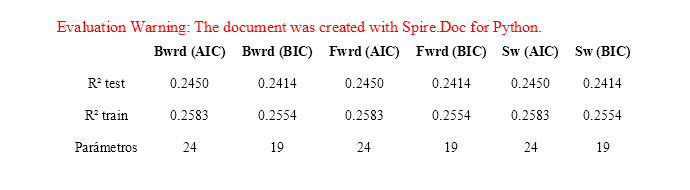

In [280]:
comparative_table_html_izq_pct = f"""
<!DOCTYPE html>
<html>
<head>
<style>
/* Aquí va tu CSS */
table {{
  table-layout: fixed;
  with: auto;
  border-collapse: collapse;
  margin: 10px;
}}

td, th {{
  height: auto;
  padding: 8px;
  font-size: 14px;
  text-align: center;
}}
</style>
</head>
<body>
<table>
  <thead>
    <tr>
      <th></th>
      <th>Bwrd (AIC)</th>
      <th>Bwrd (BIC)</th>
      <th>Fwrd (AIC)</th>
      <th>Fwrd (BIC)</th>
      <th>Sw (AIC)</th>
      <th>Sw (BIC)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>R² test</td>
      <td>{Rsq(rl_izq_pct_backward_aic['Modelo'],izq_pct_objetivo_test,data_rl_izq_pct_backward_aic):.4f}</td>
      <td>{Rsq(rl_izq_pct_backward_bic['Modelo'],izq_pct_objetivo_test,data_rl_izq_pct_backward_bic):.4f}</td>
      <td>{Rsq(rl_izq_pct_forward_aic['Modelo'],izq_pct_objetivo_test,data_rl_izq_pct_forward_aic):.4f}</td>
      <td>{Rsq(rl_izq_pct_forward_bic['Modelo'],izq_pct_objetivo_test,data_rl_izq_pct_forward_bic):.4f}</td>
      <td>{Rsq(rl_izq_pct_stepwise_aic['Modelo'],izq_pct_objetivo_test,data_rl_izq_pct_stepwise_aic):.4f}</td>
      <td>{Rsq(rl_izq_pct_stepwise_bic['Modelo'],izq_pct_objetivo_test,data_rl_izq_pct_stepwise_bic):.4f}</td>
    </tr>
    <tr>
      <td>R² train</td>
      <td>{Rsq(rl_izq_pct_backward_aic['Modelo'],izq_pct_objetivo_train,rl_izq_pct_backward_aic['X']):.4f}</td>
      <td>{Rsq(rl_izq_pct_backward_bic['Modelo'],izq_pct_objetivo_train,rl_izq_pct_backward_bic['X']):.4f}</td>
      <td>{Rsq(rl_izq_pct_forward_aic['Modelo'],izq_pct_objetivo_train,rl_izq_pct_forward_aic['X']):.4f}</td>
      <td>{Rsq(rl_izq_pct_forward_bic['Modelo'],izq_pct_objetivo_train,rl_izq_pct_forward_bic['X']):.4f}</td>
      <td>{Rsq(rl_izq_pct_stepwise_aic['Modelo'],izq_pct_objetivo_train,rl_izq_pct_stepwise_aic['X']):.4f}</td>
      <td>{Rsq(rl_izq_pct_stepwise_bic['Modelo'],izq_pct_objetivo_train,rl_izq_pct_stepwise_bic['X']):.4f}</td>
    </tr>
    <tr>
      <td>Parámetros</td>
      <td>{len(rl_izq_pct_backward_aic['Modelo'].params)}</td>
      <td>{len(rl_izq_pct_backward_bic['Modelo'].params)}</td>
      <td>{len(rl_izq_pct_forward_aic['Modelo'].params)}</td>
      <td>{len(rl_izq_pct_forward_bic['Modelo'].params)}</td>
      <td>{len(rl_izq_pct_stepwise_aic['Modelo'].params)}</td>
      <td>{len(rl_izq_pct_stepwise_bic['Modelo'].params)}</td>
    </tr>
  </tbody>
</table>
"""

document = Document()
sec = document.AddSection()
paragraph = sec.AddParagraph()
paragraph.AppendHTML(comparative_table_html_izq_pct)

imageStream = document.SaveImageToStreams(0, ImageType.Bitmap)

with open("./comparative_table_img_izq_pct.png",'wb') as imageFile:
    imageFile.write(imageStream.ToArray())
document.Close()

try:
  img = PILImage.open("./comparative_table_img_izq_pct.png")
  bbox = (10,10,700,200) 
  cropped_img = img.crop(bbox)
  cropped_img.save("./comparative_table_img_izq_pct.png") 
  display(Image(filename='./comparative_table_img_izq_pct.png'))
except:
  display(Image(filename='./comparative_table_img_izq_pct.png'))


<h5>Izquierda</h5>

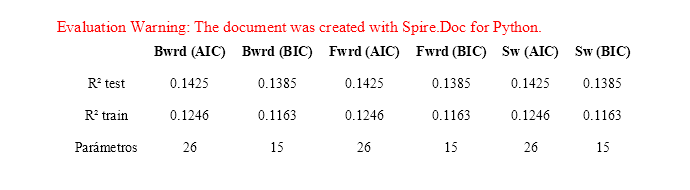

In [281]:
comparative_table_html_izquierda = f"""
<!DOCTYPE html>
<html>
<head>
<style>
/* Aquí va tu CSS */
table {{
  table-layout: fixed;
  with: auto;
  border-collapse: collapse;
  margin: 10px;
}}

td, th {{
  height: auto;
  padding: 8px;
  font-size: 14px;
  text-align: center;
}}
</style>
</head>
<body>
<table>
  <thead>
    <tr>
      <th></th>
      <th>Bwrd (AIC)</th>
      <th>Bwrd (BIC)</th>
      <th>Fwrd (AIC)</th>
      <th>Fwrd (BIC)</th>
      <th>Sw (AIC)</th>
      <th>Sw (BIC)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>R² test</td>
      <td>{Rsq(rl_izquierda_backward_aic['Modelo'],izquierda_objetivo_test,data_rl_izquierda_backward_aic):.4f}</td>
      <td>{Rsq(rl_izquierda_backward_bic['Modelo'],izquierda_objetivo_test,data_rl_izquierda_backward_bic):.4f}</td>
      <td>{Rsq(rl_izquierda_forward_aic['Modelo'],izquierda_objetivo_test,data_rl_izquierda_forward_aic):.4f}</td>
      <td>{Rsq(rl_izquierda_forward_bic['Modelo'],izquierda_objetivo_test,data_rl_izquierda_forward_bic):.4f}</td>
      <td>{Rsq(rl_izquierda_stepwise_aic['Modelo'],izquierda_objetivo_test,data_rl_izquierda_stepwise_aic):.4f}</td>
      <td>{Rsq(rl_izquierda_stepwise_bic['Modelo'],izquierda_objetivo_test,data_rl_izquierda_stepwise_bic):.4f}</td>
    </tr>
    <tr>
      <td>R² train</td>
      <td>{Rsq(rl_izquierda_backward_aic['Modelo'],izquierda_objetivo_train,rl_izquierda_backward_aic['X']):.4f}</td>
      <td>{Rsq(rl_izquierda_backward_bic['Modelo'],izquierda_objetivo_train,rl_izquierda_backward_bic['X']):.4f}</td>
      <td>{Rsq(rl_izquierda_forward_aic['Modelo'],izquierda_objetivo_train,rl_izquierda_forward_aic['X']):.4f}</td>
      <td>{Rsq(rl_izquierda_forward_bic['Modelo'],izquierda_objetivo_train,rl_izquierda_forward_bic['X']):.4f}</td>
      <td>{Rsq(rl_izquierda_stepwise_aic['Modelo'],izquierda_objetivo_train,rl_izquierda_stepwise_aic['X']):.4f}</td>
      <td>{Rsq(rl_izquierda_stepwise_bic['Modelo'],izquierda_objetivo_train,rl_izquierda_stepwise_bic['X']):.4f}</td>
    </tr>
    <tr>
      <td>Parámetros</td>
      <td>{len(rl_izquierda_backward_aic['Modelo'].params)}</td>
      <td>{len(rl_izquierda_backward_bic['Modelo'].params)}</td>
      <td>{len(rl_izquierda_forward_aic['Modelo'].params)}</td>
      <td>{len(rl_izquierda_forward_bic['Modelo'].params)}</td>
      <td>{len(rl_izquierda_stepwise_aic['Modelo'].params)}</td>
      <td>{len(rl_izquierda_stepwise_bic['Modelo'].params)}</td>
    </tr>
  </tbody>
</table>
"""

document = Document()
sec = document.AddSection()
paragraph = sec.AddParagraph()
paragraph.AppendHTML(comparative_table_html_izquierda)

imageStream = document.SaveImageToStreams(0, ImageType.Bitmap)

with open("./comparative_table_img_izquierda.png",'wb') as imageFile:
    imageFile.write(imageStream.ToArray())
document.Close()

try:
  img = PILImage.open("./comparative_table_img_izquierda.png")
  bbox = (10,10,700,200) 
  cropped_img = img.crop(bbox)
  cropped_img.save("./comparative_table_img_izquierda.png") 
  display(Image(filename='./comparative_table_img_izquierda.png'))
except:
  display(Image(filename='./comparative_table_img_izquierda.png'))

<h3>Modelos a partir de metodos aleatorios de seleccion de variables</h3>